<a href="https://colab.research.google.com/github/ol287/Learning-from-data/blob/main/Week10%20workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo

The first part of this file is a demo - run all of this part (and look over the code) so you can go to the interpretability section where the exercises are

#Imports

Import TensorFlow and anything else you may need

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout
from tensorflow.keras.activations import relu
from tensorflow.keras import Model

TensorFlow version: 2.17.1


#Modelling

###MNIST

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def decimals_to_one_hots(decimal_numbers, num_classes):
    one_hots = []
    for decimal_number in decimal_numbers:
        one_hot = np.zeros(num_classes)
        one_hot[decimal_number] = 1
        one_hots.append(one_hot)
    return np.array(one_hots)

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

# y_train = add_label_noise(y_train, noise_level = 0.25)

y_train = decimals_to_one_hots(y_train,10)
y_test = decimals_to_one_hots(y_test,10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Visualise the dataset

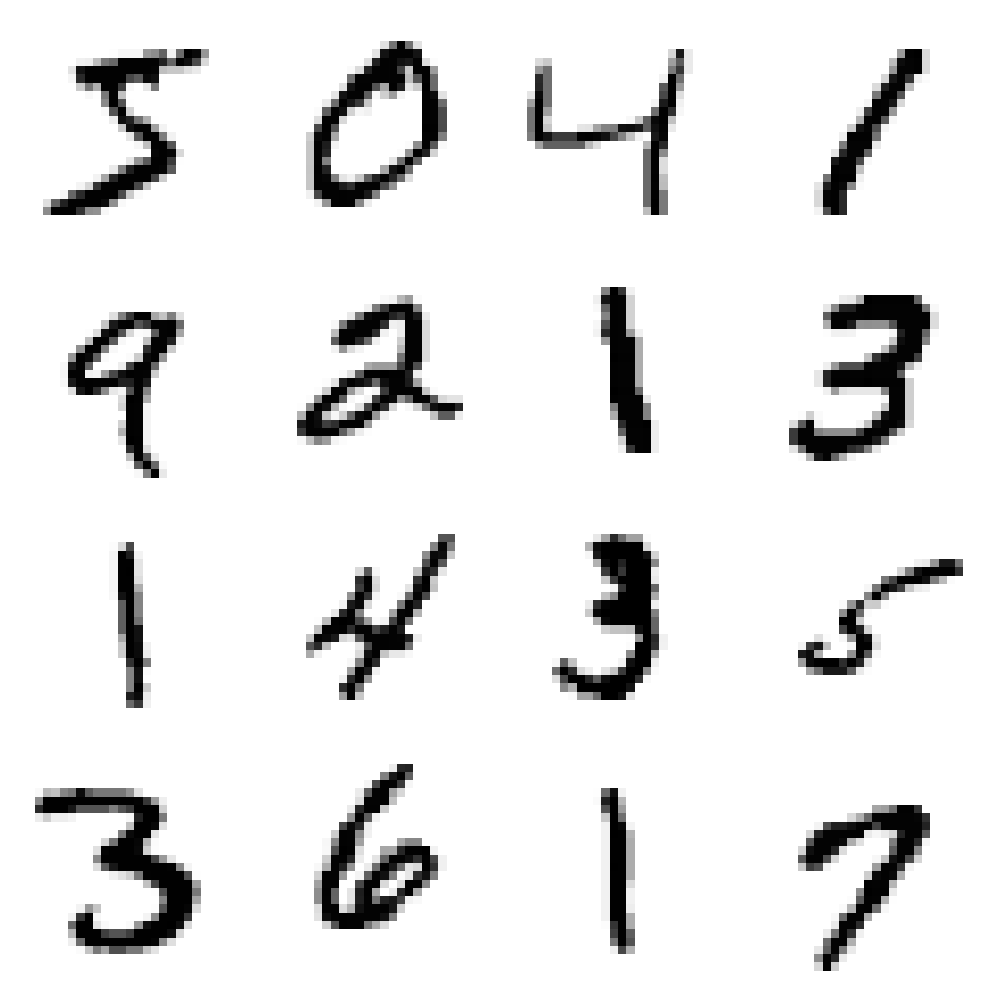

In [3]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the images and display them in the subplots
for i in range(16):
    # Assuming images are numpy arrays
    axes[i].imshow(x_train[i], cmap = 'Greys')  # Use cmap='gray' for grayscale images
    axes[i].axis('off')  # Turn off axis labels and ticks

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()

Use `tf.data` to batch and shuffle the dataset:

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [5]:
# Define input shape
input_shape = (28, 28, 1)

# Define input layer
input_layer = Input(shape=input_shape)

# Convolutional layer with activation
conv1 = Conv2D(32, 3, activation='relu')(input_layer)
drop1 = Dropout(0.75)(conv1)

# Flatten layer
flatten = Flatten()(drop1)

# Dense output layer with softmax activation
output = Dense(10, activation='softmax')(flatten)

# Create the model
model = Model(inputs=input_layer, outputs=output)

Choose an optimizer and loss function for training:

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [7]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [8]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [9]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [10]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

AttributeError: 'Mean' object has no attribute 'reset_states'

The image classifier is now trained to ~98% accuracy on this dataset.

#Interpretability

###Imports

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.2 MB/s eta 0:00:00


In [ ]:
import shap

import keras

##SHAP

Condition SHAP on part of the train set

In [ ]:
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

shap_expectations = shap.DeepExplainer(model, background)

Test it out by asking it to explain the first ten test set values

Here, we can see that on the y axis there are 10 different samples as we wanted

On the x axis, we can see the ten different classes

The pink areas are the positive explanations - why this sample belongs to this class

The blue areas indicate pink areas being present elsewhere - negative explanations are a combination of positive explanations for all other classes

Note that this image's colours may skew depending on very strong explanations making others look dimmer. You can use the same function to plot individual images or a smaller set of images. This is shown below.

In [ ]:
shap_values = shap_expectations.shap_values(x_test[0:10])

shap.image_plot(shap_values, x_test[0:10])

In [ ]:
#Individual Plot
shap.image_plot(shap_values[0][0], x_test[wanted_wrongs[0]])

#Exercises

###Exc 1:


We run interpretability on correct and incorrect samples to check different facets of the model.

Find and separate the correct answers from the incorrect ones

In [ ]:
pred_test_one_hot = model(x_test)

pred_test = np.argmax(pred_test_one_hot, axis=1)
true_test = np.argmax(y_test, axis=1)

In [ ]:
corrects = np.where(pred_test == true_test)[0]
wrongs = np.where(pred_test != true_test)[0]

Let's find out where most of the wrong predictions and correct predictions are

Display the distribution of numbers in the corrects and wrongs

In [ ]:
# Count the occurrences of each number (0 to 9)
counts = np.bincount(true_test[corrects])

# Generate x-axis labels (numbers 0 to 9)
x_labels = np.arange(10)

# Create a bar chart to visualize the distribution
plt.bar(x_labels, counts)

In [11]:
# Count the occurrences of each number (0 to 9)
counts = np.bincount(true_test[wrongs])

# Generate x-axis labels (numbers 0 to 9)
x_labels = np.arange(10)

# Create a bar chart to visualize the distribution
plt.bar(x_labels, counts)

NameError: name 'true_test' is not defined

I expect some confusion between 1s and 7s because I used to have a lot of trouble with this as a kid, but surprisingly the model doesn't - let's check to see that it's doing ok

Use SHAP to visualise 10 correctly predicted 7s' explanations

In [12]:
#First we get all the true 7s
all_7s = np.where(true_test==7)[0]

#Then we get all the predicted 2s
predicted_7s = np.where(pred_test==7)[0]

#Now we get the intersection of this set
correct_7s = np.intersect1d(all_7s, predicted_7s)

shap_values = shap_expectations.shap_values(x_test[correct_7s[:10]])

shap.image_plot(shap_values, x_test[correct_7s[:10]])

NameError: name 'true_test' is not defined

Can you see if the distinguishing feature of 7s have been correctly selected here?

Use SHAP to visualise 10 correctly predicted 1s' explanations

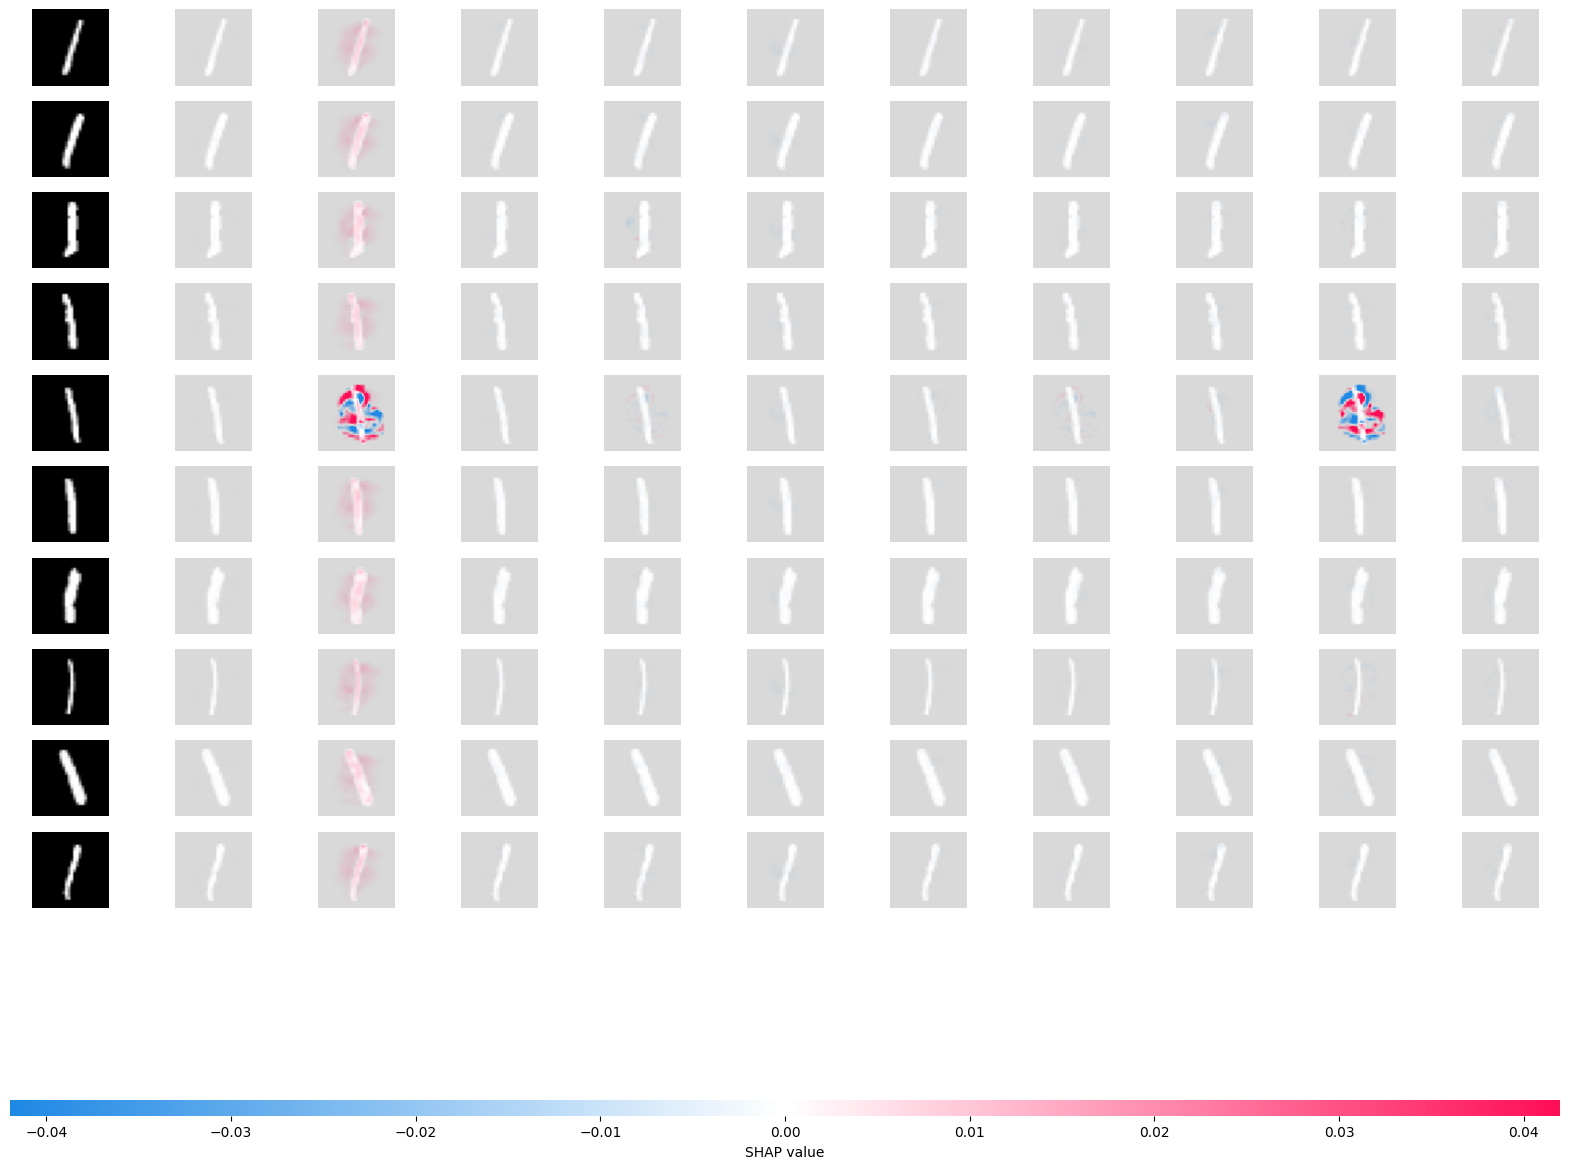

In [ ]:
#First we get all the true 7s
all_1s = np.where(true_test==1)[0]

#Then we get all the predicted 2s
predicted_1s = np.where(pred_test==1)[0]

#Now we get the intersection of this set
correct_1s = np.intersect1d(all_1s, predicted_1s)

shap_values = shap_expectations.shap_values(x_test[correct_1s[:10]])

shap.image_plot(shap_values, x_test[correct_1s[:10]])

What seems to be the distinguishing feature of the 1s as shown here?

The correct ones have a roughly even distribution but the incorrect predictions have a much more skewed distribution - what analysis can you perform here by looking at these?

What numbers seem like they're getting confused?

Let's see if there's any significant mispredictions happening

Plot the predicted numbers against the true labels to see if there are any systematic errors occuring here

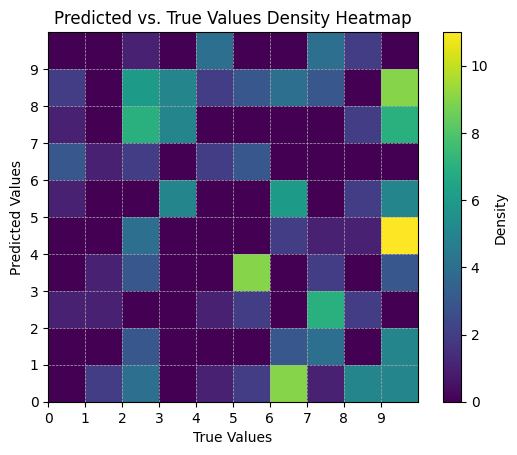

In [ ]:
heatmap, xedges, yedges = np.histogram2d(true_test[wrongs], pred_test[wrongs], bins=(range(11), range(11)))

# Plot the heatmap using imshow
plt.imshow(heatmap.T, origin='lower', extent=[0, 10, 0, 10], interpolation='nearest')
plt.colorbar(label='Density')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values Density Heatmap')
plt.xticks(range(10))
plt.yticks(range(10))
plt.grid(True, linestyle='--', linewidth=0.5)

In my model, 9s get misrepresented as 4s the most. It's an intuitive error, but let's see what the model is seeing

Use SHAP to visualise the errors on 10 of these numbers

Note - you may need to individually plot these to visualise the colours properly (select which picture you want in the shap values array and then in the x_test)

Can you figure out why these numbers are being mis-classified?

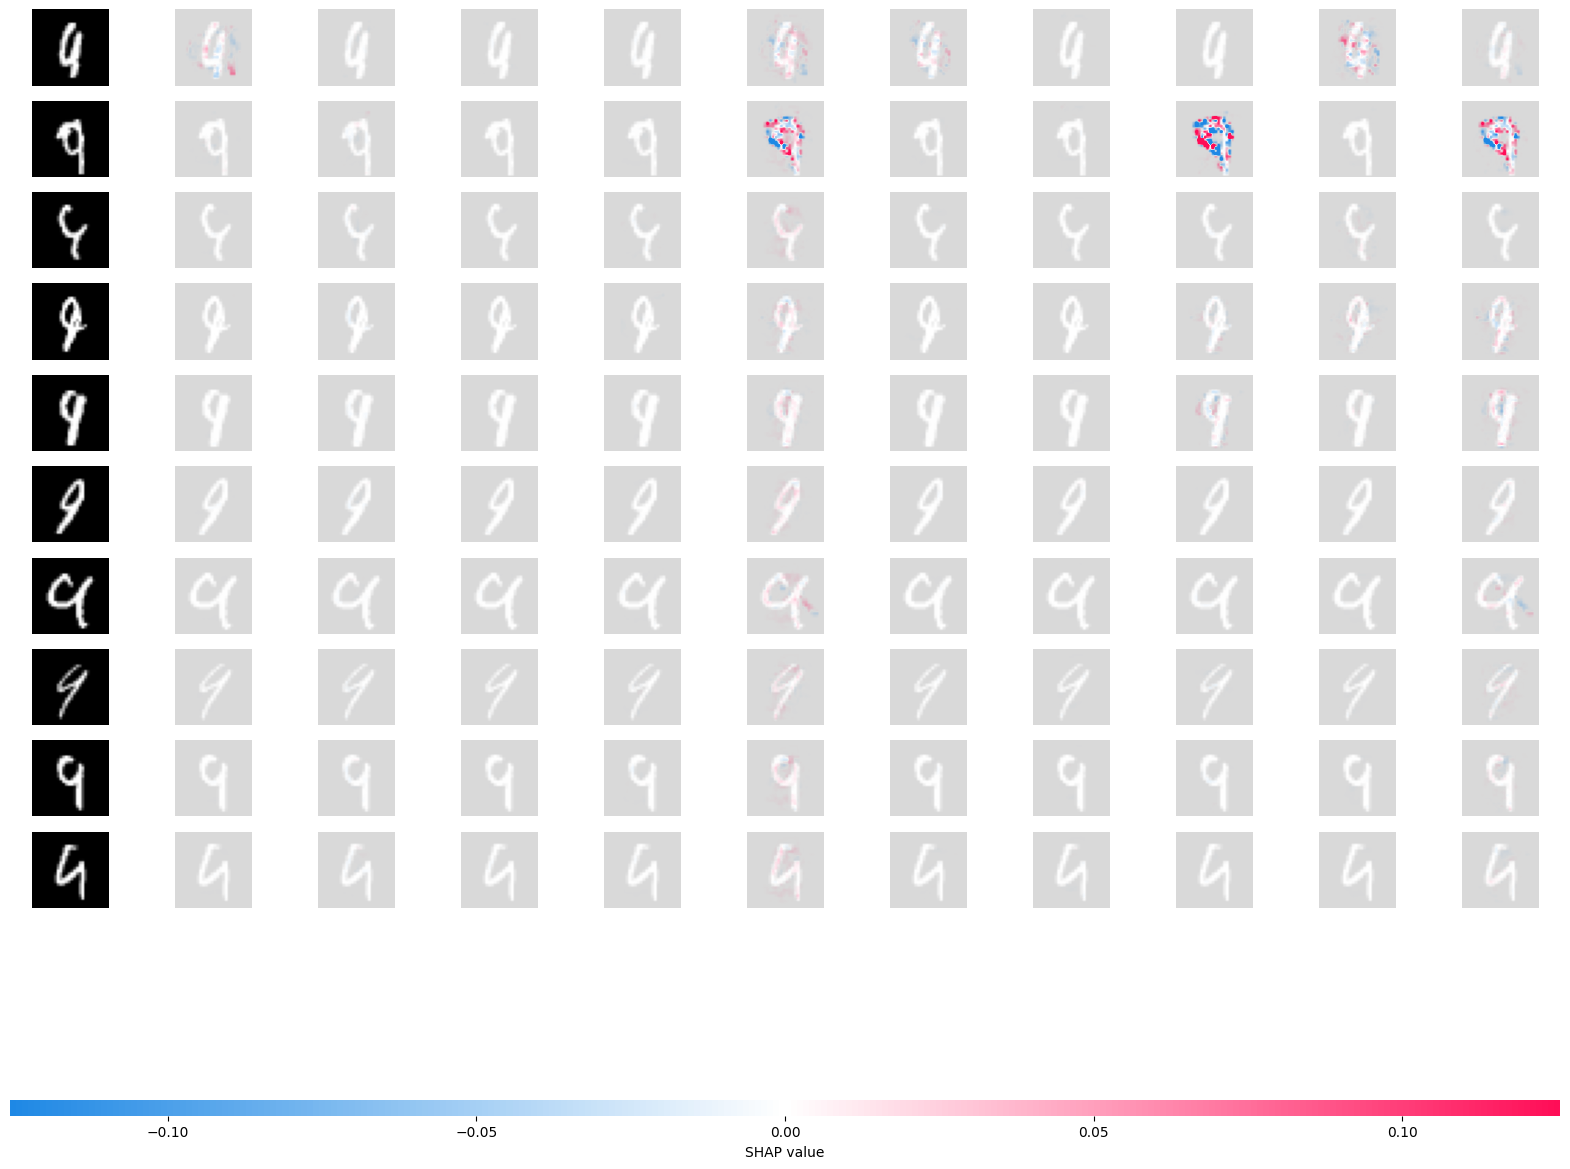

In [ ]:
#First we get all the true 7s
all_9s = np.where(true_test==9)[0]

#Then we get all the predicted 2s
predicted_4s = np.where(pred_test==4)[0]

#Now we get the intersection of this set
wanted_wrongs = np.intersect1d(all_9s, predicted_4s)

shap_values = shap_expectations.shap_values(x_test[wanted_wrongs[:10]])

shap.image_plot(shap_values, x_test[wanted_wrongs[:10]])

We need to find out if there are any alternative ways of writing numbers that the model struggles with - what numbers and corresponding styles would you recommend augmenting the dataset with? You can work with the person next to you to speed this up

###Exc 2:

Visualise filters

Preamble

In [ ]:
import keras

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

Find the name of the convolutional layer of the model we want to visualise

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 32)        0     

In [ ]:
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv2d"

layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

We need to construct an image to give to the filter visualiser so that it can maximises the filter activation -

Write a function that makes a random image with depth and height that can be passed to the filter visualiser - remember, the model has to be able to process this image

In [ ]:
def initialize_image(img_width, img_height, channels = 1):
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, channels))
    return img

There needs to be some kind of hyperparameter tuning to ensure that the filters are coming out right - tune the iterations and the learning rate

tf.Tensor(212.01741, shape=(), dtype=float32)


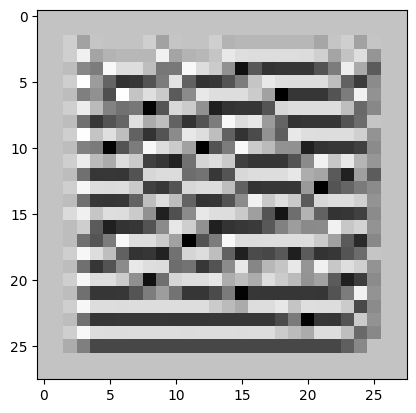

In [ ]:
#Hyperparameters
iterations = 3000
learning_rate = 10

#Which filter do you want to visualise?
filter_index = 0

img = initialize_image(28,28)
for iteration in range(iterations):
    loss, img = gradient_ascent_step(img, filter_index, learning_rate)


plt.imshow(img[0], cmap='Greys')
print(loss)

Great, now wrap it up into a function!

In [ ]:
def visualize_filter(filter_index, iterations=30, learning_rate=10):
    # We run gradient ascent for 20 steps
    img = initialize_image(28,28)
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    return loss, img

Can you write a script that visualises all the filters in the neural network? Discuss with the person sitting next to you

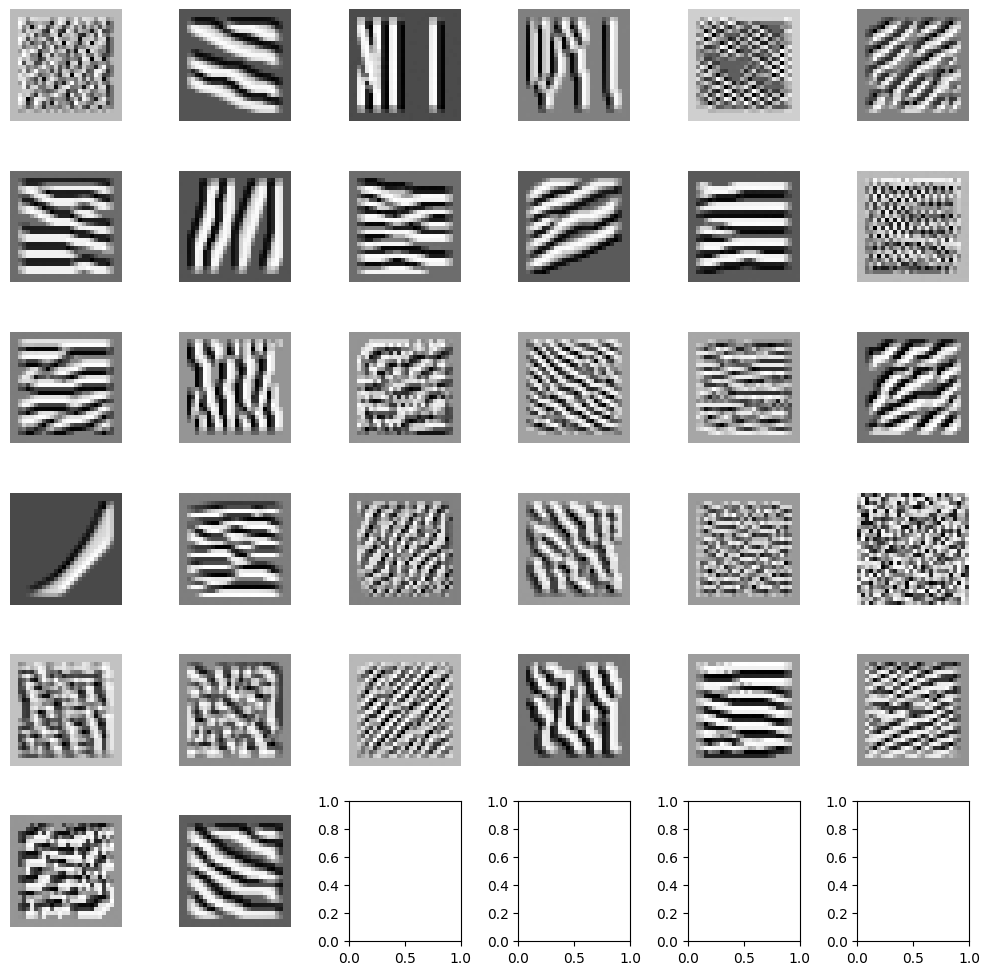

In [ ]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(32):
    # print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index, iterations=300)
    all_imgs.append(img[0])


# Create a 4x4 grid of subplots
fig, axes = plt.subplots(6, 6, figsize=(10, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the images and display them in the subplots
for i in range(32):
    # Assuming images are numpy arrays
    axes[i].imshow(all_imgs[i], cmap = 'Greys')  # Use cmap='gray' for grayscale images
    axes[i].axis('off')  # Turn off axis labels and ticks

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()